# Spatial Wright-Fisher simulation profiling

### Chris Porras

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
%matplotlib inline
from scipy.ndimage.filters import laplace
import time

In [8]:
def SS_WF_sim(pop_size,mu,s,m,num_reps,num_gen,dims):
    #Pre-allocate and initialize
    f = np.zeros((num_gen,num_reps)+dims)
    f[0] = 1/pop_size
    for j in range(num_gen-1):
        #Wright-Fisher diffusion w/Stepping Stone migration
        df = mu*(1-2*f[j])-s*f[j]*(1-f[j]) \
        +m*laplace(f[j],mode='wrap')
        #bounds allele frequencies
        p = np.clip(a= f[j] + df ,a_min=0,a_max=1)
        #genetic drift sampling
        f[j+1]= np.random.binomial(pop_size,p)/pop_size
    return f

In [9]:
def implicit_mut_sim(pop_size,s,m,num_reps,num_gen,dims):
    #Pre-allocate and initialize
    f = np.zeros((num_gen,num_reps)+dims)
    f[0] = 1/pop_size
    for j in range(num_gen-1):
        #Wright-Fisher diffusion w/Stepping Stone migration
        df = -s*f[j]*(1-f[j]) + m*laplace(f[j],mode='wrap')
        #bounds allele frequencies
        p = np.clip(a= f[j] + df ,a_min=0,a_max=1)
        #genetic drift sampling w/ implicit mut
        f[j+1] = np.random.binomial(pop_size,p)/pop_size
        # if all elements of a replicate at time j are 0, reset to 1/N
        f[j+1,np.count_nonzero(f[j],axis=(1,2))==0] = 1/pop_size
    return f

In [10]:
pop_size = 10**3
mu = 10**-4
s = 10**-2
m = 10**-1
num_reps = 10
num_gen = 10**4
dims = (10,10)

In [100]:
%timeit f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps,num_gen,dims)

116 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [97]:
%timeit f_nomu = implicit_mut_sim(pop_size,s,m,num_reps,num_gen,dims)

111 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Compare runtimes for parallel replicates vs. generations

#### explicit mutation

In [16]:
num_reps = 1
num_gen = 10**5
print(("total gens simulated = %.e")%(num_gen*num_reps))
%timeit f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps,num_gen,dims)

total gens simulated = 1e+05
7.31 s ± 53.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
num_reps = 10
num_gen = 10**4
print(("total gens simulated = %.e")%(num_gen*num_reps))
%timeit f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps,num_gen,dims)

total gens simulated = 1e+05
1.77 s ± 43.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
num_reps = 10**2
num_gen = 10**3
print(("total gens simulated = %.e")%(num_gen*num_reps))
%timeit f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps,num_gen,dims)

total gens simulated = 1e+05
1.1 s ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### implicit mutation

In [19]:
num_reps = 1
num_gen = 10**5
print(("total gens simulated = %.e")%(num_gen*num_reps))
%timeit f_nomu = implicit_mut_sim(pop_size,s,m,num_reps,num_gen,dims)

total gens simulated = 1e+05
8.05 s ± 97.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
num_reps = 10
num_gen = 10**4
print(("total gens simulated = %.e")%(num_gen*num_reps))
%timeit f_nomu = implicit_mut_sim(pop_size,s,m,num_reps,num_gen,dims)

total gens simulated = 1e+05
1.37 s ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
num_reps = 10**2
num_gen = 10**3
print(("total gens simulated = %.e")%(num_gen*num_reps))
%timeit f_nomu = implicit_mut_sim(pop_size,s,m,num_reps,num_gen,dims)

total gens simulated = 1e+05
633 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Vizualize timeseries for each simulation and report fraction of zeros

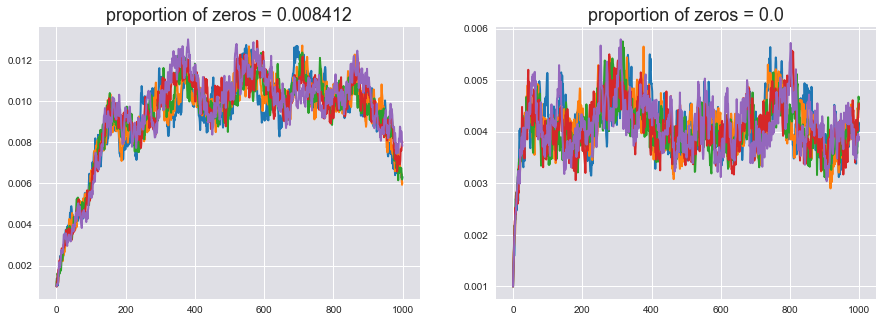

In [95]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.mean(f_mu,axis=(2,3))[:,0:])
ax[0].set_title(f"proportion of zeros = {np.sum(f_mu == 0)/f_mu.size}")
ax[1].plot(np.mean(f_nomu,axis=(2,3))[:,0:])
ax[1].set_title(f'proportion of zeros = {np.sum(f_nomu == 0)/f_nomu.size}')

plt.show()

### Measure runtimes as a function of num_gen, num_reps, dims

#### Increasing powers of num_gen

In [200]:
max_i = 6 # max i for num_gen = 10**i

time_gen = np.zeros((max_i,2))

for i in (range(1,max_i+1)):
    #explicit mu
    time_gen[i-1,0] = time.time()
    f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps=1,num_gen=10**i,dims=(10,10))
    time_gen[i-1,0] = time.time()-time_gen[i-1,0]
    # Implicit mu
    time_gen[i-1,1] = time.time()
    f_nomu = implicit_mut_sim(pop_size,s,m,num_reps=1,num_gen=10**i,dims=(10,10))
    time_gen[i-1,1] = time.time()-time_gen[i-1,1]

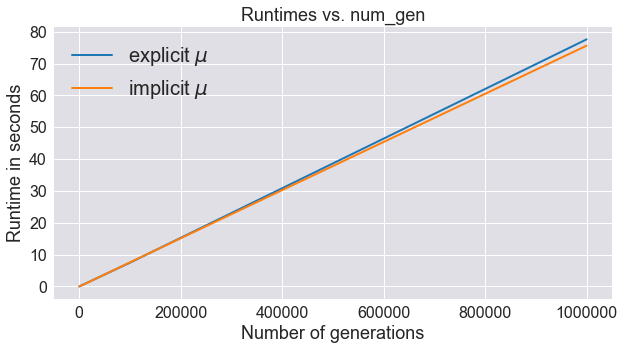

In [199]:
plt.figure(figsize=(10,5))
plt.plot(10**np.arange(1,time_gen.shape[0]+1),time_gen[:,0],label=r"explicit $\mu$")
plt.plot(10**np.arange(1,time_gen.shape[0]+1),time_gen[:,1],label=r'implicit $\mu$')
plt.title("Runtimes vs. num_gen")
plt.xlabel("Number of generations")
plt.ylabel("Runtime in seconds")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.show()

#### Increasing factors of num_reps

In [133]:
max_i = 10 # max i for num_gen = i*10

time_reps = np.zeros((max_i,2))

for i in (range(1,max_i+1)):
    #explicit mu
    time_reps[i-1,0] = time.time()
    f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps=i*10,num_gen=10**4,dims=(10,10))
    time_reps[i-1,0] = time.time()-time_reps[i-1,0]
    # Implicit mu
    time_reps[i-1,1] = time.time()
    f_nomu = implicit_mut_sim(pop_size,s,m,num_reps=i*10,num_gen=10**4,dims=(10,10))
    time_reps[i-1,1] = time.time()-time_reps[i-1,1]

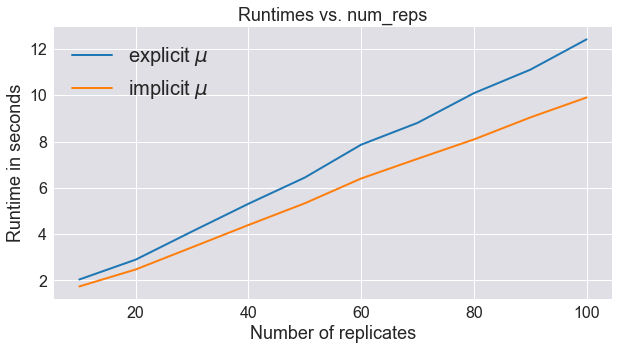

In [145]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,time_reps.shape[0]+1)*10,time_reps[:,0],label=r"explicit $\mu$")
plt.plot(np.arange(1,time_reps.shape[0]+1)*10,time_reps[:,1],label=r'implicit $\mu$')
plt.title("Runtimes vs. num_reps")
plt.xlabel("Number of replicates")
plt.ylabel("Runtime in seconds")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.show()

#### Increasing factors of dims^2

In [142]:
max_i = 10 # max i for num_gen = i*10

time_dims = np.zeros((max_i,2))

for i in (range(1,max_i+1)):
    #explicit mu
    time_dims[i-1,0] = time.time()
    f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps=1,num_gen=10**4,dims=(i*10,i*10))
    time_dims[i-1,0] = time.time()-time_dims[i-1,0]
    # Implicit mu
    time_dims[i-1,1] = time.time()
    f_nomu = implicit_mut_sim(pop_size,s,m,num_reps=1,num_gen=10**4,dims=(i*10,i*10))
    time_dims[i-1,1] = time.time()-time_dims[i-1,1]

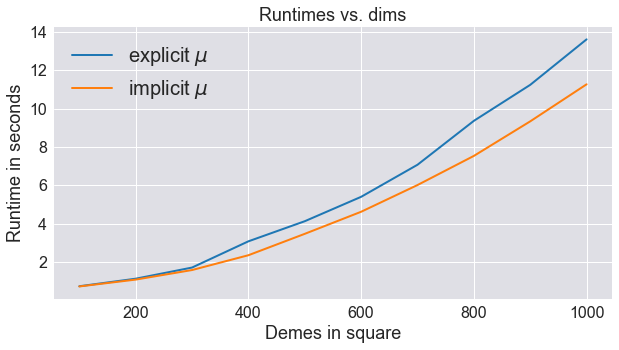

In [164]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,(time_dims.shape[0]+1))*10**2,time_dims[:,0],label=r"explicit $\mu$")
plt.plot(np.arange(1,(time_dims.shape[0]+1))*10**2,time_dims[:,1],label=r'implicit $\mu$')
plt.title("Runtimes vs. dims")
plt.xlabel("Demes in square")
plt.ylabel("Runtime in seconds")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=20)
plt.show()

> Runtimes blow up with $t > 10^5$, num_reps and spatial dims scale more moderately. Implicit $\mu$ has a slight speed advantage to explicit. 

### Measure memory requirements as a function of num_gen, num_reps, dims

In [153]:
%load_ext memory_profiler

In [154]:
pop_size = 10**3
mu = 10**-4
s = 10**-2
m = 10**-1

#### Low vs. high num_gen

In [155]:
#Low num_gen

In [156]:
%%memit
f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps=1,num_gen=10**4,dims=(10,10))

peak memory: 169.80 MiB, increment: 7.31 MiB


In [157]:
%%memit
f_nomu = implicit_mut_sim(pop_size,s,m,num_reps=1,num_gen=10**4,dims=(10,10))

peak memory: 156.20 MiB, increment: 7.44 MiB


In [158]:
#High num_gen

In [159]:
%%memit
f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps=1,num_gen=10**6,dims=(10,10))

peak memory: 914.22 MiB, increment: 762.67 MiB


In [160]:
%%memit
f_nomu = implicit_mut_sim(pop_size,s,m,num_reps=1,num_gen=10**6,dims=(10,10))

peak memory: 1676.68 MiB, increment: 762.46 MiB


#### Low vs. high num_reps

In [165]:
# Low num_reps

In [183]:
%%memit
f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps=1,num_gen=10**4,dims=(10,10))

peak memory: 163.48 MiB, increment: 0.00 MiB


In [184]:
%%memit
f_nomu = implicit_mut_sim(pop_size,s,m,num_reps=1,num_gen=10**4,dims=(10,10))

peak memory: 163.48 MiB, increment: 0.00 MiB


In [173]:
# High num_reps

In [172]:
%%memit
f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps=100,num_gen=10**4,dims=(10,10))

peak memory: 925.34 MiB, increment: 765.22 MiB


In [174]:
%%memit
f_nomu = implicit_mut_sim(pop_size,s,m,num_reps=100,num_gen=10**4,dims=(10,10))

peak memory: 1688.35 MiB, increment: 763.01 MiB


#### Low vs. high dims

In [175]:
#low dims

In [185]:
%%memit
f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps=1,num_gen=10**4,dims=(10,10))

peak memory: 163.48 MiB, increment: 0.00 MiB


In [186]:
%%memit
f_nomu = implicit_mut_sim(pop_size,s,m,num_reps=1,num_gen=10**4,dims=(10,10))

peak memory: 163.48 MiB, increment: 0.00 MiB


In [178]:
#High dims

In [179]:
%%memit
f_mu = SS_WF_sim(pop_size,mu,s,m,num_reps=1,num_gen=10**4,dims=(100,100))

peak memory: 925.96 MiB, increment: 763.50 MiB


In [180]:
%%memit
f_nomu = implicit_mut_sim(pop_size,s,m,num_reps=1,num_gen=10**4,dims=(100,100))

peak memory: 1689.36 MiB, increment: 763.40 MiB


> Seems like implicit mu peaks higher than explicit mu and high dims/reps/gen blows up memory usage. Too much variability in peak memory reported to be useful => Need a better way to vizualize memory usage over time... 